In [1]:
import base64
import io

import httpx
from IPython.display import HTML
from PIL import Image


def resize_base64_image(image_url, max_size=(512, 512)):
    """
    Resize an image from a URL.

    Args:
    image_url (str): URL of the image to resize.
    max_size (tuple): Desired maximum size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Get the image
    response = httpx.get(image_url)
    img = Image.open(io.BytesIO(response.content))

    # Calculate the new size maintaining the aspect ratio
    original_width, original_height = img.size
    ratio = min(max_size[0] / original_width, max_size[1] / original_height)
    new_size = (int(original_width * ratio), int(original_height * ratio))

    # Resize the image
    resized_img = img.resize(new_size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def plt_img_base64(image_data):
    # Create an HTML img tag with the Base64 image data as the source
    image_html = f'<img src="data:image/jpeg;base64,{image_data}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

In [2]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
image_data = resize_base64_image(image_url)


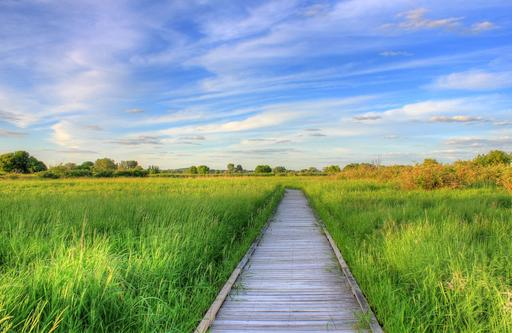

In [3]:
plt_img_base64(image_data)

In [4]:
import os
from operator import itemgetter
from typing import Optional

import gradio as gr
import opencc
from dotenv import load_dotenv
from langchain.memory import ConversationBufferMemory
from langchain_community.callbacks.manager import get_openai_callback
from langchain_core.messages.base import get_msg_title_repr
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
)
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai.chat_models.azure import AzureChatOpenAI
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_together.llms import Together

load_dotenv()


# Use OpenRouter over OpenAI
class ChatOpenRouter(ChatOpenAI):
    openai_api_base: str
    openai_api_key: str
    model_name: str

    def __init__(self, model_name: str, openai_api_key: Optional[str] = None, openai_api_base: str = "https://openrouter.ai/api/v1", **kwargs):
        openai_api_key = openai_api_key or os.getenv("OPENROUTER_API_KEY")
        super().__init__(openai_api_base=openai_api_base, openai_api_key=openai_api_key, model_name=model_name, **kwargs)


memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

system_prompt = """
You are a science communicator specializing in astronomy. Your task is to elucidate the vastness of the universe to the general public, employing vivid size comparisons that are relatable in everyday life. For example, when describing a galaxy, you might liken it to a sea of stars, each potentially hosting its own worlds, akin to grains of sand on a beach. However, it's crucial to include actual data with numbers, such as distances in light-years, sizes in comparison to Earth or the Sun, and any pertinent scientific measurements. Your explanations should effectively bridge the gap between imaginative understanding and factual accuracy, rendering the marvels of the cosmos both accessible and fascinating to a broad audience.
"""


# Translate to Traditional Chinese
def s2hk(content):
    converter = opencc.OpenCC("s2hk")
    return converter.convert(content)


def get_answer(question, system_prompt=system_prompt, image_data=image_data, show_info=False, **kwargs):
    prompt = ChatPromptTemplate.from_messages(
        messages=[
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            (
                "user",
                [
                    {"type": "text", "text": "{question}"},
                    {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}},
                ],
            ),
        ]
    )
    if show_info:
        prompt.pretty_print()

    # Use kwargs to override default parameters if provided
    model_params = {
        "model_name": "gpt-4o",
        "temperature": 0.7,
        "max_tokens": 4096,
    }
    model_params.update(kwargs)

    # model = ChatOpenRouter(**model_params)
    # model = ChatOpenAI(**model_params)
    model = AzureChatOpenAI(**model_params)
    # model = Together(**model_params)

    chain = (
        RunnablePassthrough.assign(
            chat_history=RunnableLambda(
                memory.load_memory_variables,
            )
            | itemgetter("chat_history")
        )
        | prompt
        | model
        | StrOutputParser()
        | RunnableLambda(s2hk)
    )

    # Display callback and response
    with get_openai_callback() as callback:
        response = chain.invoke({"question": question, "image_data": image_data})
        if show_info:
            print(get_msg_title_repr("Callback", bold=True), end="\n\n")
            print(callback, end="\n\n")
            print(get_msg_title_repr("Response", bold=True), end="\n\n")
        print(response)

    memory.save_context({"question": question}, {"response": response})

    return prompt, response


# memory.load_memory_variables({})

In [5]:
system_prompt = """
"""

question = "What do you see in the image and what can you imagine?"

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
image_data = resize_base64_image(image_url)

In [6]:
get_answer(question, system_prompt, image_data)

The image showcases a serene, scenic landscape with a wooden boardwalk or path cutting through a lush, green field. The sky above is expansive, featuring wisps of clouds against a backdrop of blue. The greenery appears vibrant and well-maintained, suggesting a healthy, thriving environment.

Imagining this scene, one might sense a peaceful, calming atmosphere, ideal for a leisurely walk or nature exploration. The boardwalk invites you to follow its path, perhaps leading to a hidden gem like a pond, a forest, or a meadow. This setting could be perfect for birdwatching, photography, or simply enjoying the tranquility of nature. The open sky and wide field might evoke a sense of freedom and openness, making it an ideal escape from the hustle and bustle of daily life.


(ChatPromptTemplate(input_variables=['chat_history', 'image_data', 'question'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='\n')), MessagesPlaceholder(variable_name='chat_history'), HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=['question'], template='{question}'), ImagePromptTemplate(input_variables=['image_data'], template={'url': 'data:image/jpeg;base64,{image_data}'})])]),
 'The image showcases a serene, scenic landscape with a wooden boardwalk or path cutting through a lush, green field. The sky above is expansive, featuring wisps of clouds against a backdrop of blue. The greenery appears vibrant and we

In [7]:
memory.load_memory_variables({})

{'chat_history': [HumanMessage(content='What do you see in the image and what can you imagine?'),
  AIMessage(content='The image showcases a serene, scenic landscape with a wooden boardwalk or path cutting through a lush, green field. The sky above is expansive, featuring wisps of clouds against a backdrop of blue. The greenery appears vibrant and well-maintained, suggesting a healthy, thriving environment.\n\nImagining this scene, one might sense a peaceful, calming atmosphere, ideal for a leisurely walk or nature exploration. The boardwalk invites you to follow its path, perhaps leading to a hidden gem like a pond, a forest, or a meadow. This setting could be perfect for birdwatching, photography, or simply enjoying the tranquility of nature. The open sky and wide field might evoke a sense of freedom and openness, making it an ideal escape from the hustle and bustle of daily life.')]}

In [5]:
prompt

NameError: name 'prompt' is not defined